In [1]:
import sys
import json
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [2]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

In [3]:
prefix = "DD20"       # set to TDD for Thawing Degree Days

config = {
    "TDD": {
        "deltaT": 32
    },
    "DD20": {
        "deltaT": 20
    },
    "DD25": {
        "deltaT": 25
    },
}

breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / f"data/weatherstations/ACIS/{prefix}/dd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [19]:
def datestr2dayssince(datestr, since='0301'):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

In [20]:
def dayssince2date(days, year, since='0301'):
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

In [21]:
datestr2dayssince('2020-04-15')

45

In [22]:
dayssince2date(43, 2022)

datetime.date(2022, 4, 13)

### Load data

In [23]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

,id,siteID,year,breakup
0,7175,Koyukuk River at Bettles,2022,2022-05-05
1,7173,Kobuk River at Shungnak,2022,2022-05-20
2,7172,Buckland River at Buckland,2022,2022-05-21
3,7171,Yukon River at Mountain Village,2022,2022-05-10
4,7170,Yukon River at Marshall,2022,2022-05-15
...,...,...,...,...
1490,213,Buckland River at Buckland,1988,1988-05-05
1491,212,Buckland River at Buckland,1987,1987-05-22
1492,211,Buckland River at Buckland,1986,1986-05-30
1493,210,Buckland River at Buckland,1984,1984-05-23


In [24]:
climatologies = pd.read_csv(PROJPATH / f"data/weatherstations/ACIS/{prefix}/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

,GULKANA_AIRPORT,TANANA_AIRPORT,KETCHIKAN_AIRPORT,COLLEGE_OBSERVATORY,AUKE_BAY,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,SKAGWAY_AIRPORT,EAGLE,BIG_DELTA_AIRPORT,...,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,YAKUTAT_AIRPORT,ALYESKA,NENANA_MUN_AP,HOMER_AIRPORT,NORTHWAY_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,DUTCH_HARBOR,MCKINLEY_PARK
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,16.30,0.00,12.10,0.00,0.46,10.31,0.00,0.00,...,2.05,10.87,6.11,0.00,5.97,0.00,0.00,0.00,13.86,0.00
1,0.00,0.00,32.65,0.00,24.24,0.00,2.44,20.66,0.00,0.00,...,4.03,20.47,11.34,0.00,12.81,0.00,0.00,0.00,28.21,0.00
2,0.00,0.00,49.33,0.00,35.65,0.00,5.18,31.14,0.00,0.00,...,5.61,28.95,16.36,0.00,19.50,0.00,0.00,0.00,43.46,0.00
3,0.00,0.00,63.84,0.00,45.70,0.00,7.01,40.49,0.00,0.00,...,7.43,36.90,21.41,0.00,25.71,0.00,0.00,0.00,58.73,0.00
4,0.00,0.00,78.42,0.00,55.60,0.00,9.79,49.07,0.00,0.00,...,10.08,45.42,26.46,0.00,33.42,0.00,0.00,0.00,74.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2092.82,2092.45,3072.02,2304.48,2945.59,1846.82,2620.82,2924.36,2132.08,2290.79,...,2512.22,2501.16,2444.05,2283.14,2404.11,2079.82,1833.69,2402.41,2324.20,1847.51
118,2129.61,2132.31,3109.10,2345.31,2982.85,1881.20,2660.45,2962.84,2172.54,2330.00,...,2550.34,2534.38,2480.24,2323.26,2437.23,2118.09,1868.69,2444.81,2352.52,1882.85
119,2166.44,2173.10,3146.48,2386.18,3020.80,1915.63,2699.95,3000.26,2213.65,2370.12,...,2588.82,2568.21,2516.06,2363.71,2471.23,2157.32,1903.43,2488.06,2381.57,1917.44


In [25]:
dd = sorted(list(stationdata.glob("*.csv")))

In [26]:
def retrieve_dd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_dd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march1-offset][str(row.year)] - climatologies[stationname].iloc[row.days_since_march1-offset]
    except KeyError:
        return np.nan
    
def retrieve_dd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    days_since_march1 = datestr2dayssince(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[days_since_march1][str(row.year)] - climatologies[stationname].iloc[days_since_march1]
    except KeyError:
        return np.nan

### Prototyping: one location only

In [27]:
location = "Yukon River at Eagle"
breakup = breakup[breakup.siteID == location].sort_values(by='year').reset_index(drop=True)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup

,id,siteID,year,breakup,days_since_march1
0,5330,Yukon River at Eagle,1980,1980-05-03,63
1,5331,Yukon River at Eagle,1981,1981-05-07,67
2,5332,Yukon River at Eagle,1982,1982-05-14,74
3,5333,Yukon River at Eagle,1983,1983-05-02,62
4,5334,Yukon River at Eagle,1984,1984-05-09,69
5,5335,Yukon River at Eagle,1985,1985-05-16,76
6,5336,Yukon River at Eagle,1986,1986-05-11,71
7,5337,Yukon River at Eagle,1987,1987-05-09,69
8,5338,Yukon River at Eagle,1988,1988-05-02,62
9,5339,Yukon River at Eagle,1989,1989-04-29,59


In [28]:
dd[13]

PosixPath('/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS/DD20/dd_cumul_bystation/EAGLE_yearly_DD20_cumul.csv')

In [29]:
teststationDF = pd.read_csv(dd[13], skiprows=4, index_col=0)
teststationDF

,1980,1981,1983,1984,1985,1986,1987,1988,1989,1990,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
1,0.0,2.0,0.0,0.0,0.0,0.00,0.00,4.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
2,0.0,4.0,0.0,0.0,0.0,0.00,0.00,17.0,0.00,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
3,0.0,4.0,0.0,0.0,0.0,0.00,0.00,18.5,0.00,17.5,...,0.0,0.0,0.0,0.5,0.0,0.0,0.00,0.00,0.0,0.00
4,0.0,4.0,0.0,11.0,0.0,0.00,0.00,18.5,0.00,25.0,...,0.0,0.0,0.0,3.5,0.0,0.0,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2259.5,2245.0,2071.0,2245.0,1771.0,1812.38,2053.05,2203.0,2168.01,2375.0,...,2285.5,1811.5,2152.0,2544.0,2485.0,2177.0,2051.84,2621.98,2254.1,2228.38
118,2304.5,2283.0,2122.0,2286.5,1805.5,1849.38,2088.55,2244.5,2207.51,2423.0,...,2328.5,1860.5,2183.0,2587.0,2532.5,2214.5,2089.84,2659.98,2290.1,2274.88
119,2353.5,2313.0,2172.0,2327.5,1835.5,1891.88,2130.55,2280.5,2248.51,2468.5,...,2369.5,1917.5,2224.0,2620.0,2571.0,2254.0,2126.34,2700.98,2326.1,2316.38


In [30]:
breakup

,id,siteID,year,breakup,days_since_march1
0,5330,Yukon River at Eagle,1980,1980-05-03,63
1,5331,Yukon River at Eagle,1981,1981-05-07,67
2,5332,Yukon River at Eagle,1982,1982-05-14,74
3,5333,Yukon River at Eagle,1983,1983-05-02,62
4,5334,Yukon River at Eagle,1984,1984-05-09,69
5,5335,Yukon River at Eagle,1985,1985-05-16,76
6,5336,Yukon River at Eagle,1986,1986-05-11,71
7,5337,Yukon River at Eagle,1987,1987-05-09,69
8,5338,Yukon River at Eagle,1988,1988-05-02,62
9,5339,Yukon River at Eagle,1989,1989-04-29,59


In [31]:
breakup_anomaly = breakup.copy()

# for pth in dd:
#     stationname = pth.stem[:-17]
#     teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
#     breakup[stationname] = breakup.apply(
#         lambda row: retrieve_dd(row, teststationDF), axis=1)

for pth in dd:
    stationname = pth.stem[:-18]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [32]:
breakup_anomaly.columns

Index(['id', 'siteID', 'year', 'breakup', 'days_since_march1', 'ALYESKA',
       'ANCHORAGE_MERRILL_FIELD',
       'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT', 'AUKE_BAY',
       'BARROW_AIRPORT', 'BETHEL_AIRPORT', 'BETTLES_AIRPORT',
       'BIG_DELTA_AIRPORT', 'CHICKEN', 'COLD_BAY_AIRPORT',
       'COLLEGE_OBSERVATORY', 'CORDOVA_AIRPORT', 'DUTCH_HARBOR', 'EAGLE',
       'FAIRBANKS_INTL_AP', 'GULKANA_AIRPORT', 'HAINES_AIRPORT',
       'HOMER_AIRPORT', 'ILIAMNA_AIRPORT', 'JUNEAU_AIRPORT', 'KENAI_AIRPORT',
       'KETCHIKAN_AIRPORT', 'KING_SALMON_AIRPORT', 'KODIAK_AIRPORT',
       'KOTZEBUE_AIRPORT', 'MCGRATH_AP', 'MCKINLEY_PARK', 'NENANA_MUN_AP',
       'NOME_AIRPORT', 'NORTHWAY_AIRPORT', 'NORTH_POLE',
       'SAINT_PAUL_ISLAND_AIRPORT', 'SITKA_AIRPORT', 'SKAGWAY_AIRPORT',
       'TALKEETNA_AIRPORT', 'TANANA_AIRPORT', 'YAKUTAT_AIRPORT'],
      dtype='object')

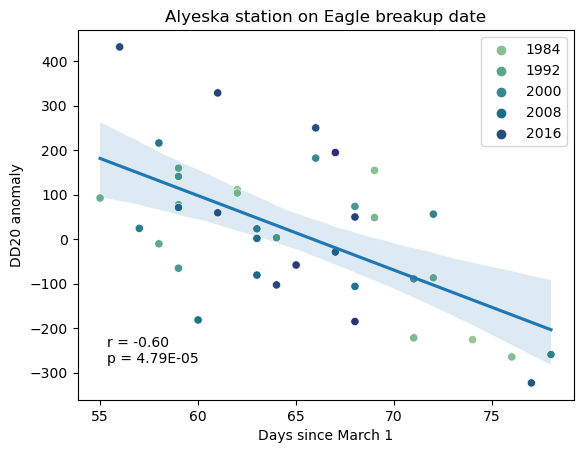

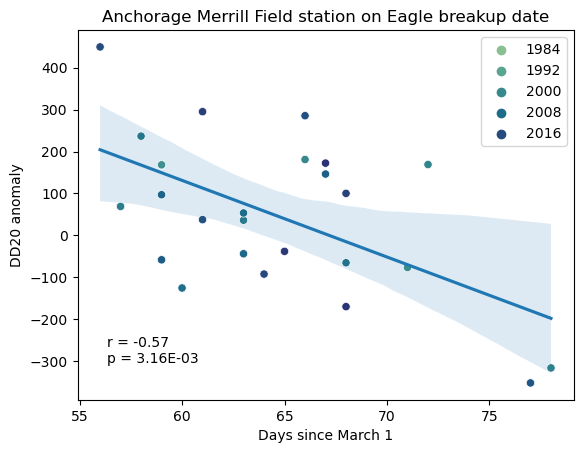

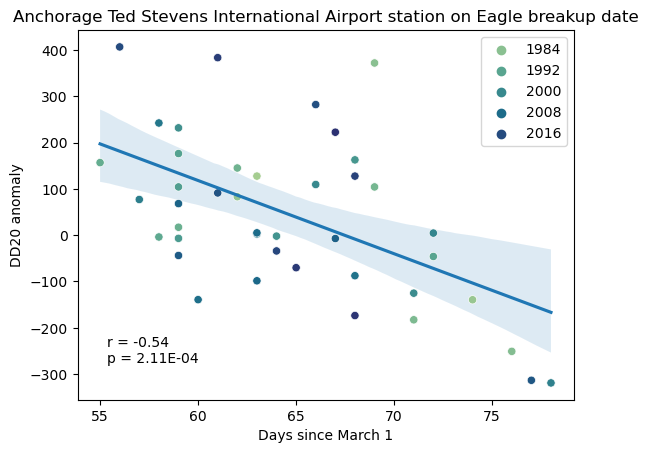

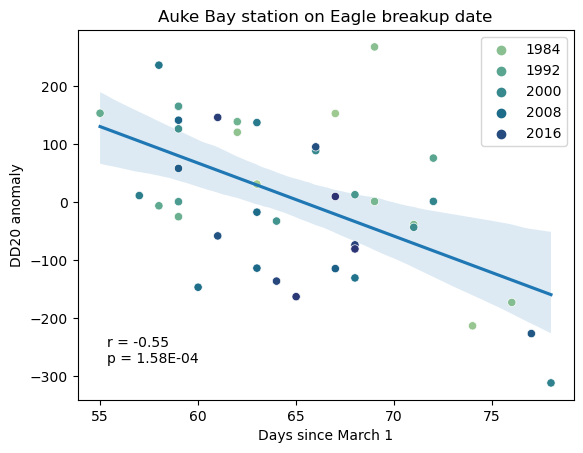

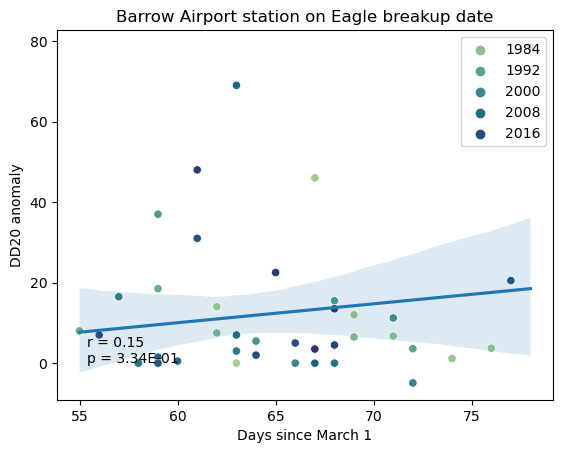

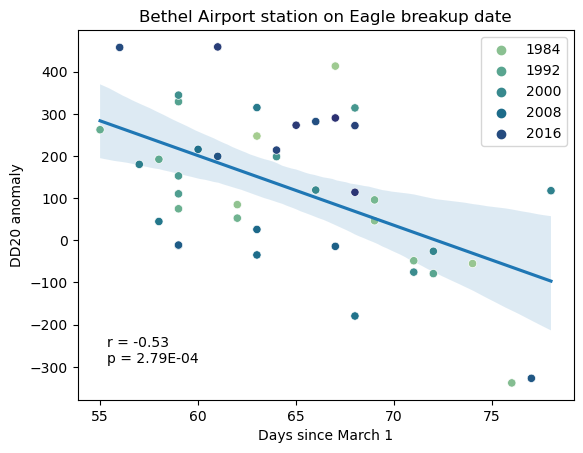

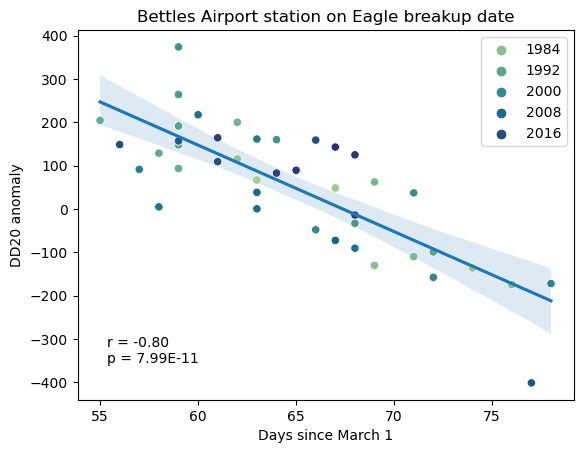

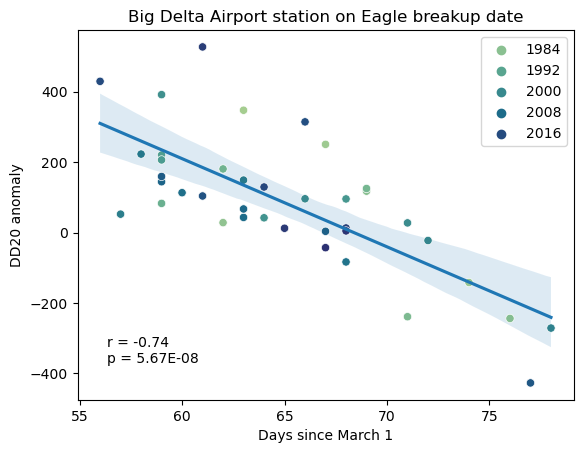

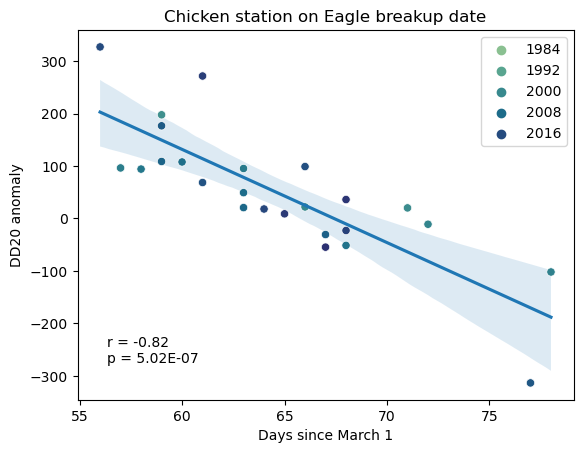

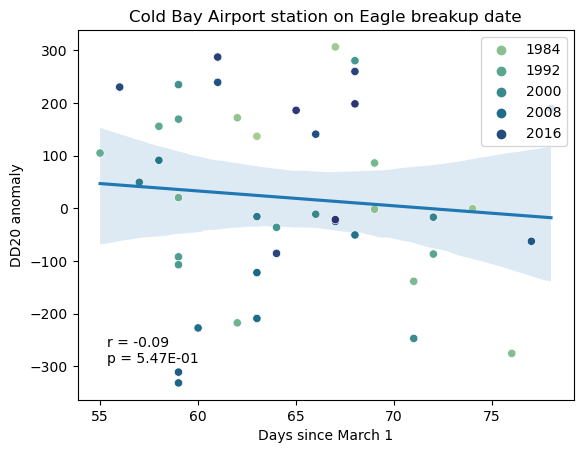

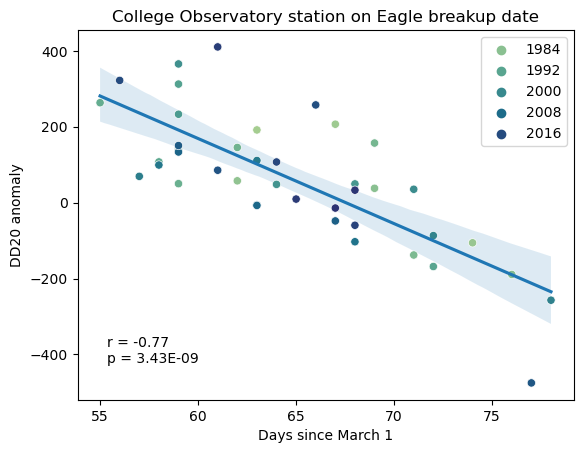

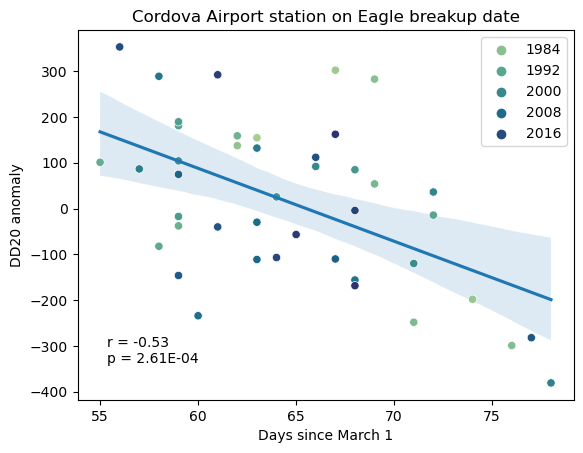

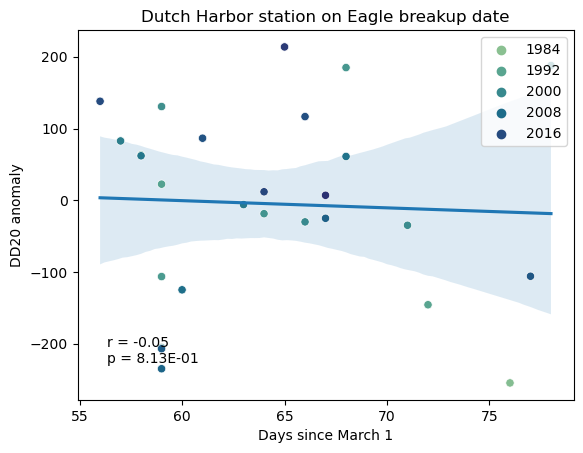

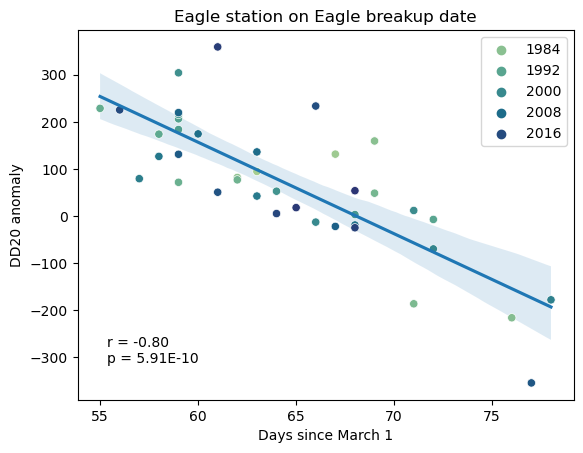

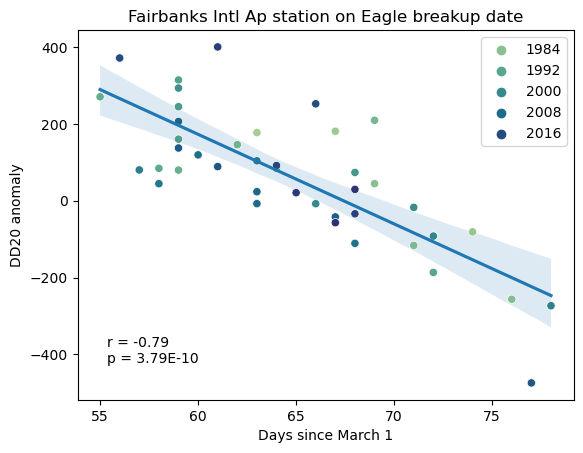

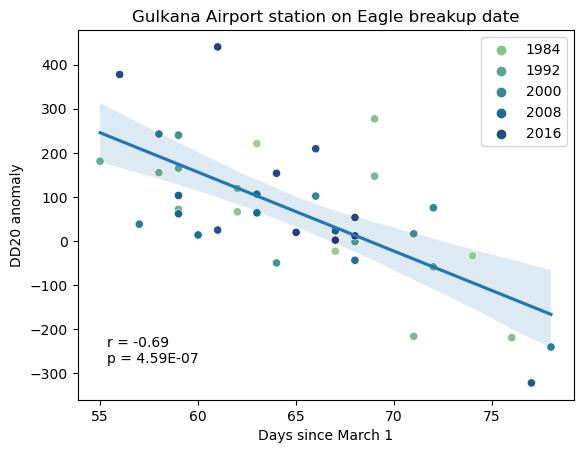

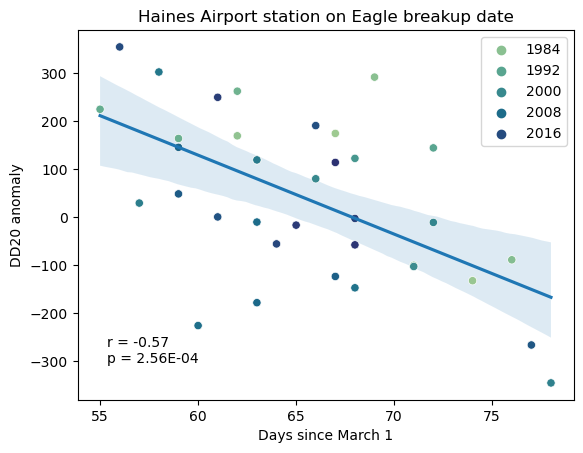

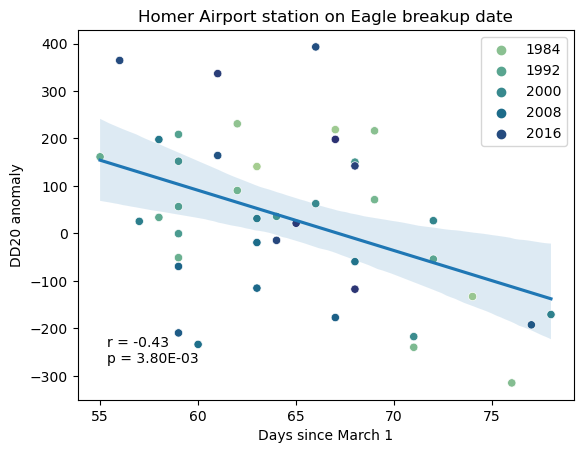

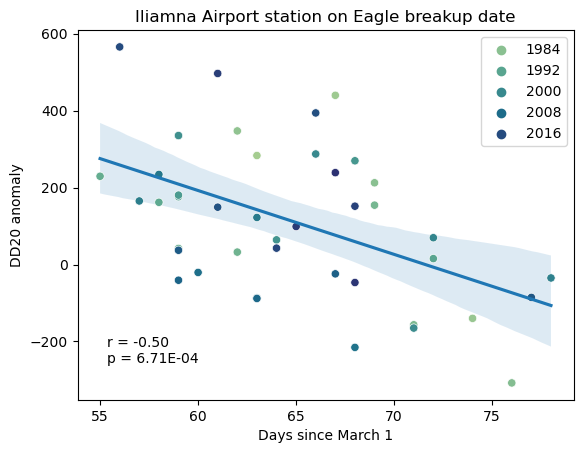

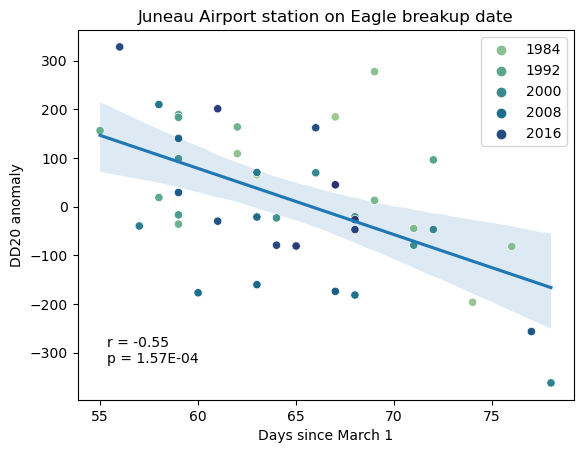

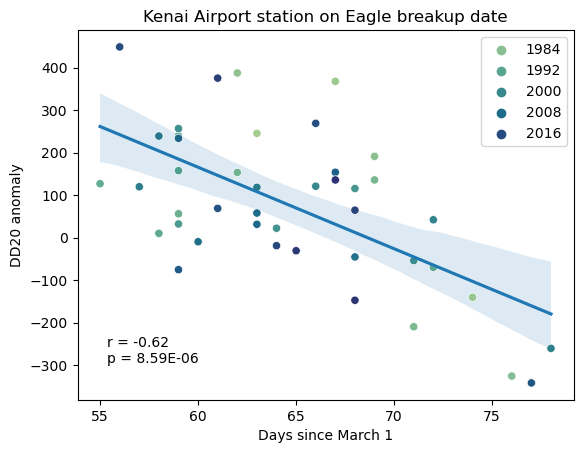

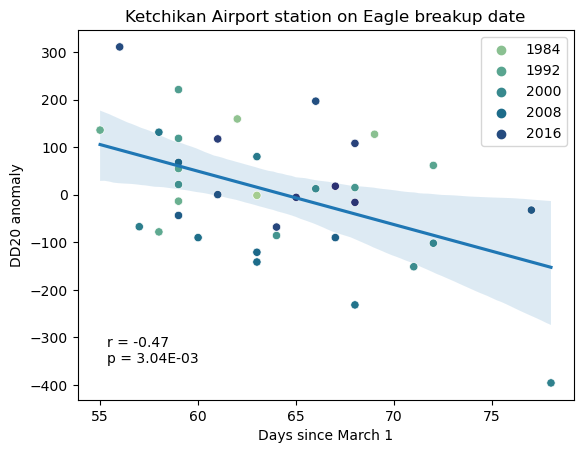

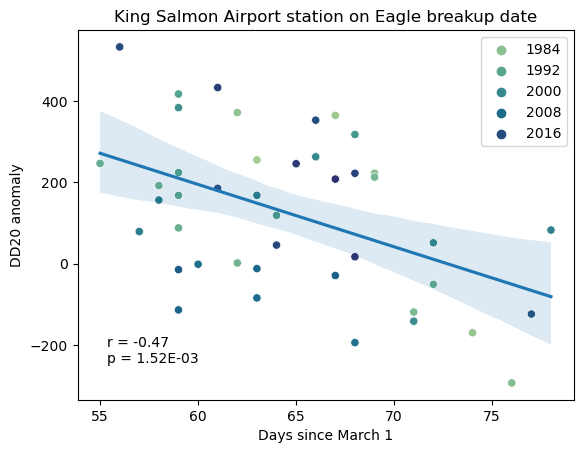

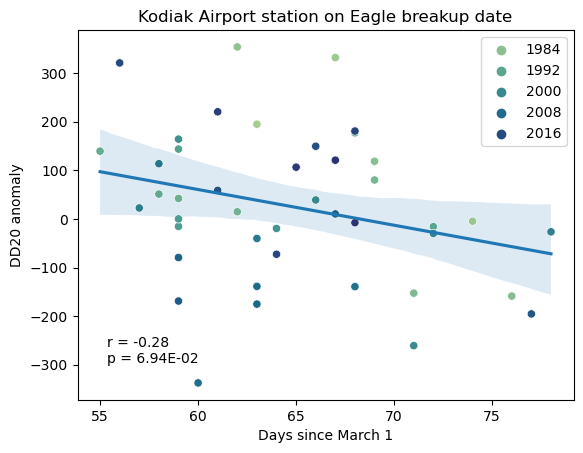

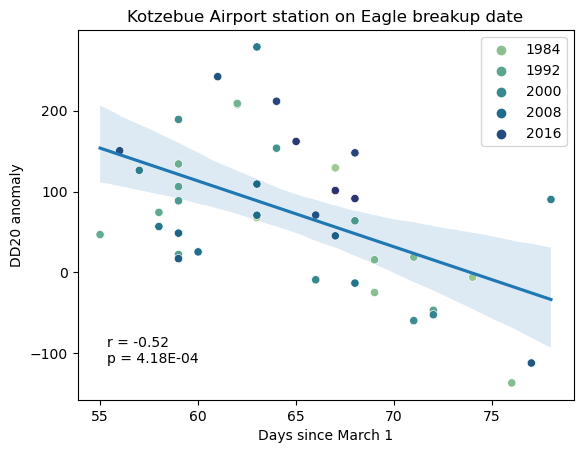

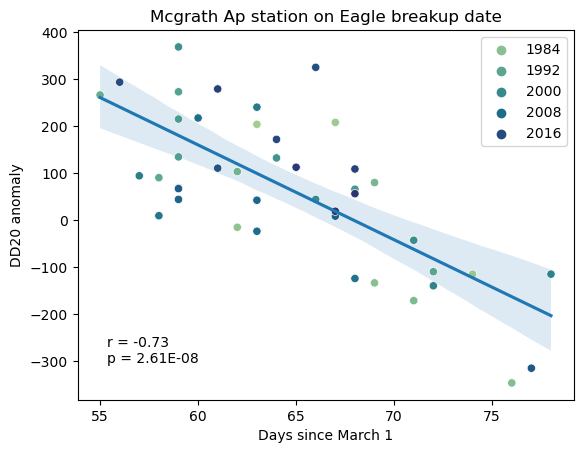

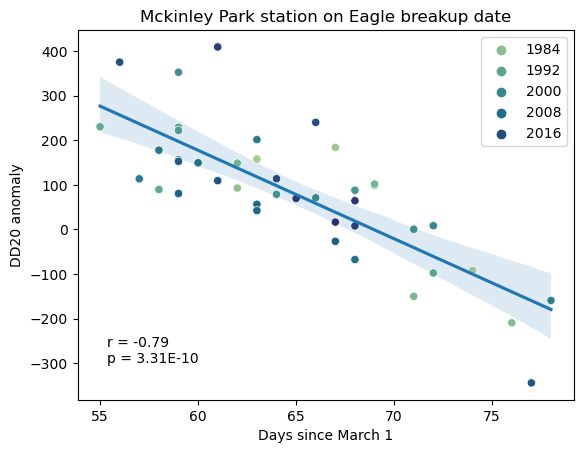

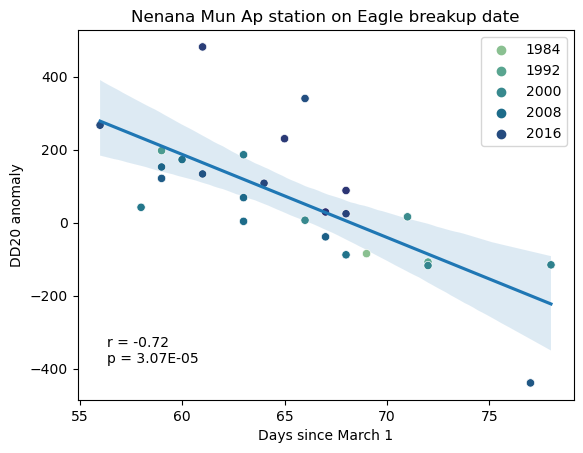

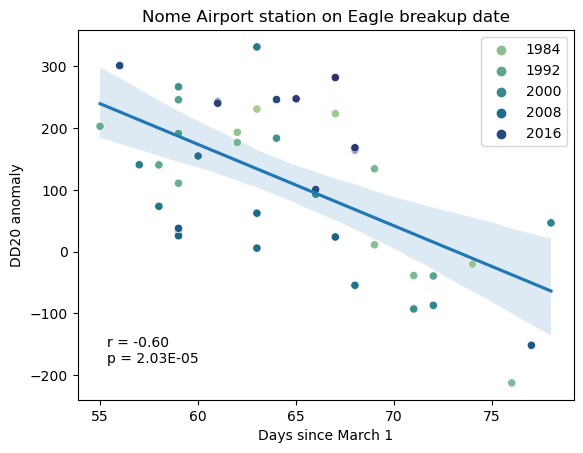

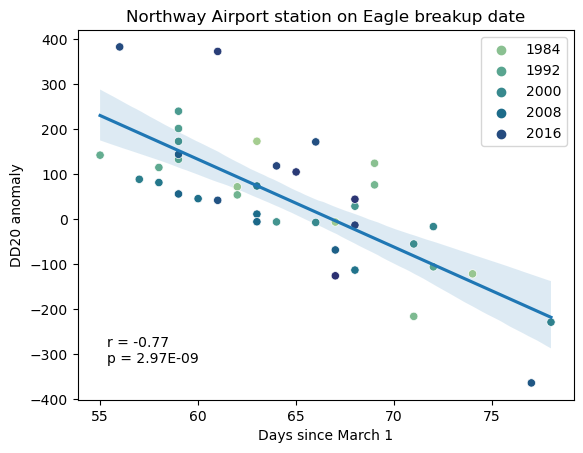

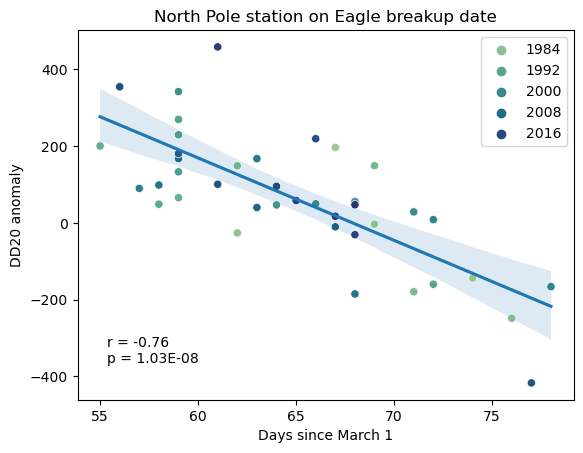

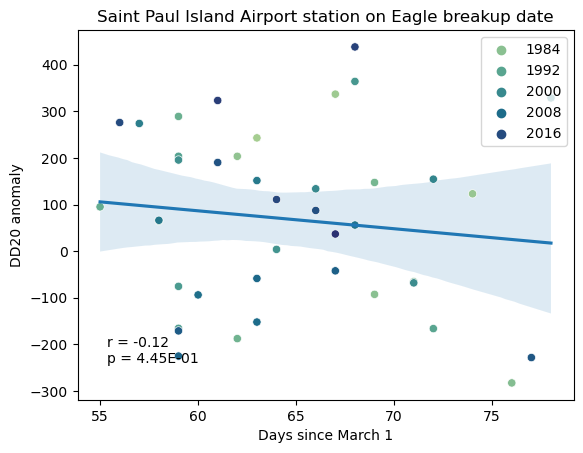

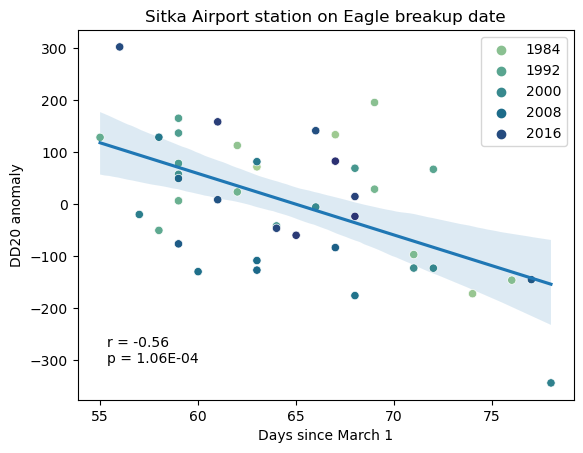

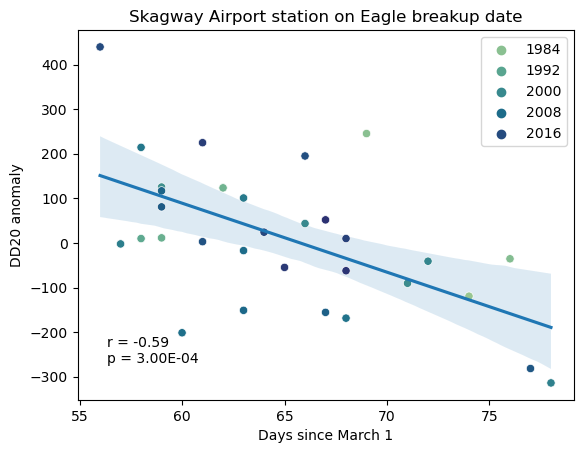

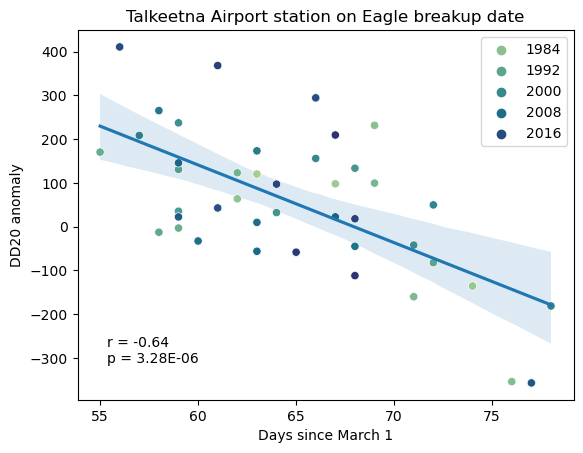

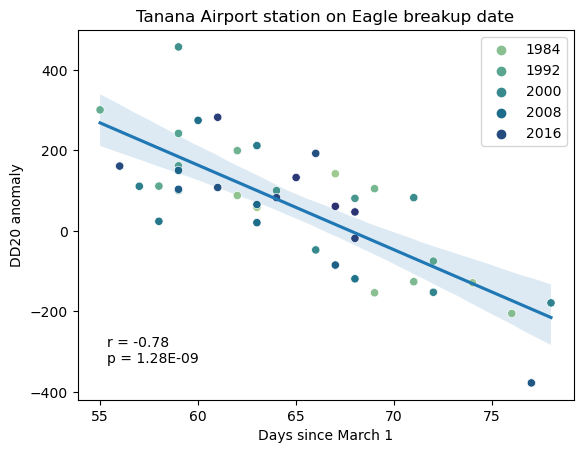

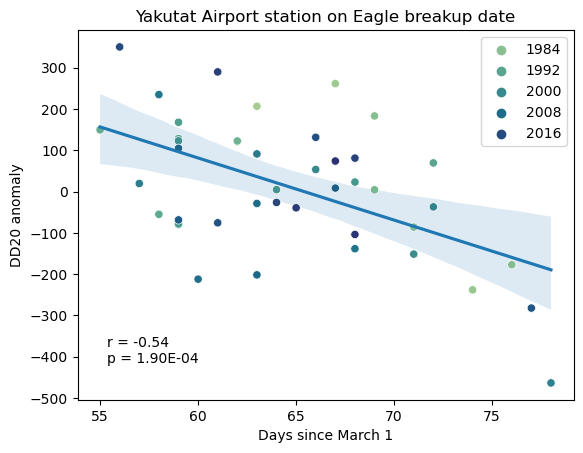

In [33]:
for stationname in breakup_anomaly.columns[5:]:
    sb.regplot(data=breakup_anomaly, x='days_since_march1', y=stationname, scatter=False)
    ax = sb.scatterplot(data=breakup_anomaly, x='days_since_march1', y=stationname, hue='year', palette="crest")
    ax.set_title(f"{stationname.replace('_', ' ').title()} station on Eagle breakup date")
    ax.set_ylabel(f"{prefix} anomaly")
    ax.set_xlabel("Days since March 1")
    plt.legend(loc='upper right')
    result = breakup_anomaly[stationname].corr(breakup_anomaly['days_since_march1'],
                method=lambda x, y: pearsonr(x, y))
    ax.text(0.06, 0.1, f'r = {result.statistic:.2f}\np = {result.pvalue:.2E}', transform=ax.transAxes)
    plt.show()

In [36]:
# breakup_only = breakup_anomaly[breakup_anomaly.columns[4:]]
breakup_only = breakup[breakup.columns[4:]]
breakup_standardized = ((breakup_only - breakup_only.mean())/breakup_only.std())
breakup_standardized

,days_since_march1
0,-0.288825
1,0.391694
2,1.582603
3,-0.458955
4,0.731954
5,1.922863
6,1.072214
7,0.731954
8,-0.458955
9,-0.969344


In [37]:
breakup_only.std().to_frame().T

,days_since_march1
0,5.877864


In [38]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
                method=lambda x, y: pearsonr(x, y)[1])

Series([], dtype: float64)

In [39]:
breakup

,id,siteID,year,breakup,days_since_march1
0,5330,Yukon River at Eagle,1980,1980-05-03,63
1,5331,Yukon River at Eagle,1981,1981-05-07,67
2,5332,Yukon River at Eagle,1982,1982-05-14,74
3,5333,Yukon River at Eagle,1983,1983-05-02,62
4,5334,Yukon River at Eagle,1984,1984-05-09,69
5,5335,Yukon River at Eagle,1985,1985-05-16,76
6,5336,Yukon River at Eagle,1986,1986-05-11,71
7,5337,Yukon River at Eagle,1987,1987-05-09,69
8,5338,Yukon River at Eagle,1988,1988-05-02,62
9,5339,Yukon River at Eagle,1989,1989-04-29,59


In [40]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
            method=lambda x, y: pearsonr(x, y)[1])

Series([], dtype: float64)

In [41]:
breakup

,id,siteID,year,breakup,days_since_march1
0,5330,Yukon River at Eagle,1980,1980-05-03,63
1,5331,Yukon River at Eagle,1981,1981-05-07,67
2,5332,Yukon River at Eagle,1982,1982-05-14,74
3,5333,Yukon River at Eagle,1983,1983-05-02,62
4,5334,Yukon River at Eagle,1984,1984-05-09,69
5,5335,Yukon River at Eagle,1985,1985-05-16,76
6,5336,Yukon River at Eagle,1986,1986-05-11,71
7,5337,Yukon River at Eagle,1987,1987-05-09,69
8,5338,Yukon River at Eagle,1988,1988-05-02,62
9,5339,Yukon River at Eagle,1989,1989-04-29,59


In [42]:
mean_EAGLE = breakup['EAGLE'].mean()
mean_EAGLE

KeyError: 'EAGLE'

In [ ]:
teststationDF

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,1.0,7.0,0.0,0.0,6.5,0.0,0.0,0.0,7.0,0.0,...,3.5,0.0,4.0,3.5,0.0,0.0,0.00,4.5,1.5,2.0
1,2.0,13.5,0.0,0.0,11.0,2.0,0.0,0.0,9.5,0.0,...,5.5,0.0,7.5,5.5,0.0,0.0,0.00,7.0,4.0,3.0
2,5.0,14.5,0.0,0.0,14.5,2.0,0.0,0.0,9.5,0.0,...,5.5,0.0,12.5,7.0,0.0,0.0,3.00,7.0,5.0,4.5
3,5.0,14.5,0.0,0.0,21.0,2.0,0.5,0.0,9.5,0.0,...,5.5,0.0,19.0,10.5,0.0,0.0,3.00,7.0,5.0,6.5
4,10.0,20.0,0.5,0.0,27.0,2.0,0.5,0.0,14.0,0.0,...,5.5,0.0,26.0,16.5,0.0,0.0,3.00,7.0,5.0,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1318.0,1511.5,853.0,1273.0,1167.5,788.0,986.0,1073.0,1155.0,1119.5,...,981.0,1100.5,1387.0,1614.0,1246.5,1257.5,1540.73,1193.5,1055.5,1210.0
118,1342.0,1533.5,871.5,1298.5,1184.0,805.0,1002.0,1092.0,1172.0,1144.0,...,1003.0,1122.0,1409.5,1636.5,1267.5,1276.0,1561.95,1214.0,1081.5,1234.0
119,1365.5,1555.5,892.0,1324.0,1198.0,823.0,1023.5,1111.0,1186.0,1166.0,...,1024.0,1148.0,1434.0,1660.0,1289.0,1299.0,1593.95,1231.0,1107.0,1258.0


In [ ]:
breakup.apply(lambda row: climatologies.loc[row.days_since_march1], axis=1)

,GULKANA_AIRPORT,TANANA_AIRPORT,KETCHIKAN_AIRPORT,COLLEGE_OBSERVATORY,AUKE_BAY,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,SKAGWAY_AIRPORT,EAGLE,BIG_DELTA_AIRPORT,...,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,YAKUTAT_AIRPORT,ALYESKA,NENANA_MUN_AP,HOMER_AIRPORT,NORTHWAY_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,DUTCH_HARBOR,MCKINLEY_PARK
0,101.07,66.19,557.42,128.15,399.01,44.18,233.98,397.61,83.28,130.20,...,203.94,240.38,182.57,108.05,208.05,87.34,42.52,143.04,232.64,45.03
1,137.53,98.62,615.61,169.02,456.33,66.33,289.78,455.67,117.44,173.18,...,253.24,280.60,225.13,149.96,249.34,123.55,68.86,190.10,263.61,66.88
2,219.12,186.66,732.12,276.11,575.53,128.56,402.96,577.80,211.26,277.19,...,356.88,365.63,316.28,255.22,332.69,211.64,135.44,303.08,328.51,133.78
3,92.28,60.12,543.27,117.96,384.41,40.88,220.94,382.94,76.05,120.51,...,192.51,229.98,172.18,98.22,198.48,79.62,37.16,132.14,225.09,40.04
4,158.90,120.71,647.36,195.71,487.54,79.63,319.68,489.14,140.03,200.62,...,280.34,303.85,248.94,176.46,271.77,145.83,85.94,219.59,281.24,82.58
5,244.62,216.90,768.33,309.05,611.14,152.66,439.11,613.51,239.40,309.73,...,389.25,390.76,344.62,291.89,358.19,240.81,158.58,339.95,348.48,156.71
6,181.69,146.54,680.83,227.40,522.11,97.90,351.79,524.37,168.63,230.79,...,309.63,328.05,274.26,206.58,295.69,170.23,105.58,252.29,299.27,102.46
7,158.90,120.71,647.36,195.71,487.54,79.63,319.68,489.14,140.03,200.62,...,280.34,303.85,248.94,176.46,271.77,145.83,85.94,219.59,281.24,82.58
8,92.28,60.12,543.27,117.96,384.41,40.88,220.94,382.94,76.05,120.51,...,192.51,229.98,172.18,98.22,198.48,79.62,37.16,132.14,225.09,40.04
9,69.18,40.36,500.08,88.27,342.92,26.73,182.86,339.07,52.78,92.89,...,158.33,199.17,143.15,70.84,169.89,58.06,21.12,100.23,201.34,25.73


<AxesSubplot: xlabel='days_since_march1', ylabel='EAGLE'>

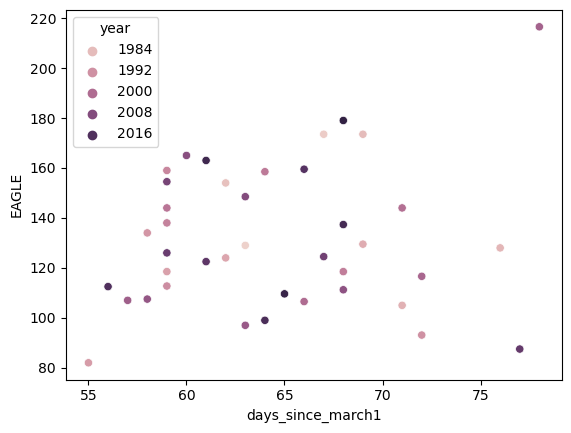

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='EAGLE', hue='year')

<AxesSubplot: xlabel='days_since_march1', ylabel='AUKE_BAY'>

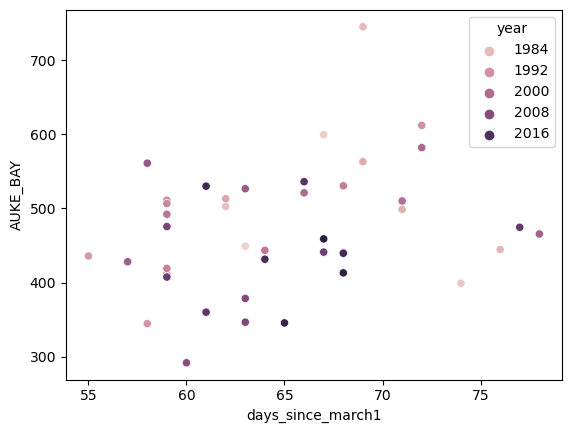

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='AUKE_BAY', hue='year')

## Model breakup by TDD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [46]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in dd:
    stationname = pth.stem[:-14-len(prefix)]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [47]:
locations = breakup.siteID.unique()
locations

array(['Koyukuk River at Bettles', 'Kobuk River at Shungnak',
       'Buckland River at Buckland', 'Yukon River at Mountain Village',
       'Yukon River at Marshall', 'Yukon River at Russian Mission',
       'Yukon River at Holy Cross', 'Kobuk River at Ambler',
       'Yukon River at Anvik', 'Kobuk River at Kobuk',
       'Gulkana River nr Gakona', 'Yukon River at Alakanuk',
       'Yukon River nr Emmonak', 'Yukon River at Kaltag',
       'Yukon River at Galena', 'Yukon River at Fort Yukon',
       'Kuskokwim River at Tuluksak', 'Kuskokwim River at Kalskag',
       'Kuskokwim River at Crooked Creek', 'Kuskokwim River at Red Devil',
       'Kuskokwim River at Sleetmute', 'Kuskokwim River at Akiak',
       'Yukon River at Ruby', 'Kuskokwim River at McGrath',
       'Yentna River at Lake Creek', 'Yukon River at Tanana',
       'Koyukuk River at Hughes', 'Koyukuk River at Allakaket',
       'Yukon River at Circle', 'Susitna River at Sunshine',
       'Yukon River at Dawson', 'Yukon River 

In [48]:
breakup_anomaly

,id,siteID,year,breakup,days_since_march1,ALYESKA,ANCHORAGE_MERRILL_FIELD,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,AUKE_BAY,BARROW_AIRPORT,...,NENANA_MUN_AP,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SAINT_PAUL_ISLAND_AIRPORT,SITKA_AIRPORT,SKAGWAY_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT,YAKUTAT_AIRPORT
0,7175,Koyukuk River at Bettles,2022,2022-05-05,65,191.67,166.45,214.32,18.59,0.50,...,29.69,288.36,-119.64,18.43,41.47,87.62,55.59,210.23,60.30,81.68
1,7173,Kobuk River at Shungnak,2022,2022-05-20,80,185.52,166.30,232.20,-19.13,20.95,...,-30.99,259.72,-180.73,-55.87,43.72,84.85,33.63,190.99,1.99,44.52
2,7172,Buckland River at Buckland,2022,2022-05-21,81,190.72,170.87,237.12,-15.68,17.62,...,-26.09,277.64,-177.28,-50.26,45.06,89.27,34.57,193.79,3.90,44.42
3,7171,Yukon River at Mountain Village,2022,2022-05-10,70,195.66,173.49,224.30,9.69,20.85,...,5.34,269.12,-142.55,-10.04,44.78,77.72,47.39,197.26,39.11,68.92
4,7170,Yukon River at Marshall,2022,2022-05-15,75,177.11,153.71,211.21,-10.82,29.42,...,-29.71,257.85,-170.55,-49.92,51.37,75.28,33.69,178.30,4.57,49.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,213,Buckland River at Buckland,1988,1988-05-05,65,95.67,NaN,144.32,144.75,7.50,...,NaN,196.86,61.86,162.91,-183.03,23.12,123.59,118.73,210.80,118.18
1491,212,Buckland River at Buckland,1987,1987-05-22,82,43.68,NaN,103.47,-33.92,-25.70,...,NaN,136.12,40.07,144.90,155.08,14.89,NaN,77.36,86.73,6.14
1492,211,Buckland River at Buckland,1986,1986-05-30,90,-235.57,NaN,-213.38,-112.32,-75.23,...,NaN,-152.13,-309.50,-281.67,-108.83,-141.99,-113.36,-186.08,-196.86,-120.82
1493,210,Buckland River at Buckland,1984,1984-05-23,83,145.39,NaN,418.40,283.80,-19.42,...,-133.66,17.25,121.45,-7.14,-121.68,214.47,260.05,218.26,-177.48,182.54


In [49]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix=f"{prefix}_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception(f"Sorry, the {stationnames} isn't in valid names: {breakupDF.columns}")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['days_since_march1'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,  
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )        
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='days_since_march1', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='days_since_march1', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel(f"{prefix} anomaly")
                ax.set_ylabel("Days since March 1")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
                if show_plots:
                    plt.show()
    return outputrecords
    

Make plots for all on breakup date

In [60]:
calculate_corr(save_plots=True)

[{'stationname': 'ALYESKA',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.0311280638043461,
  'rvalue': -0.3501988149363215,
  'r2value': 0.12263920998280395},
 {'stationname': 'ANCHORAGE_MERRILL_FIELD',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.10885101090193426,
  'rvalue': -0.3285214279355082,
  'r2value': 0.10792632861278531},
 {'stationname': 'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.063317022900923,
  'rvalue': -0.2926727914987353,
  'r2value': 0.0856573628836622},
 {'stationname': 'AUKE_BAY',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.09612692786386576,
  'rvalue': -0.2667572636818541,
  'r2value': 0.07115943772703023},
 {'stationname': 'BARROW_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0.5287327560820347,
  'rvalue': -0.1012584368061974,
  'r2value': 0.01025327102443467},
 {'stationname': 'BETHEL_AIRPORT',
  'location': 'Koyukuk River at Bettles',
  'pvalue': 0

In [62]:
outpath

PosixPath('/Users/christine/Projects/2023_Riverice/data/breakupdata/working')

In [55]:
returnrec = calculate_corr(locations=['Yukon River at Eagle'], 
                           stationnames=['CHICKEN'], save_plots=True)

In [56]:
returnrec = calculate_corr()

In [57]:
resultsDF_p = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2 = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [58]:
with open(outpath / f"breakupday_{prefix}_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p.to_csv(dst)
with open(outpath / f"breakupday_{prefix}_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between DD20 anomaly on breakup date, and breakup date')

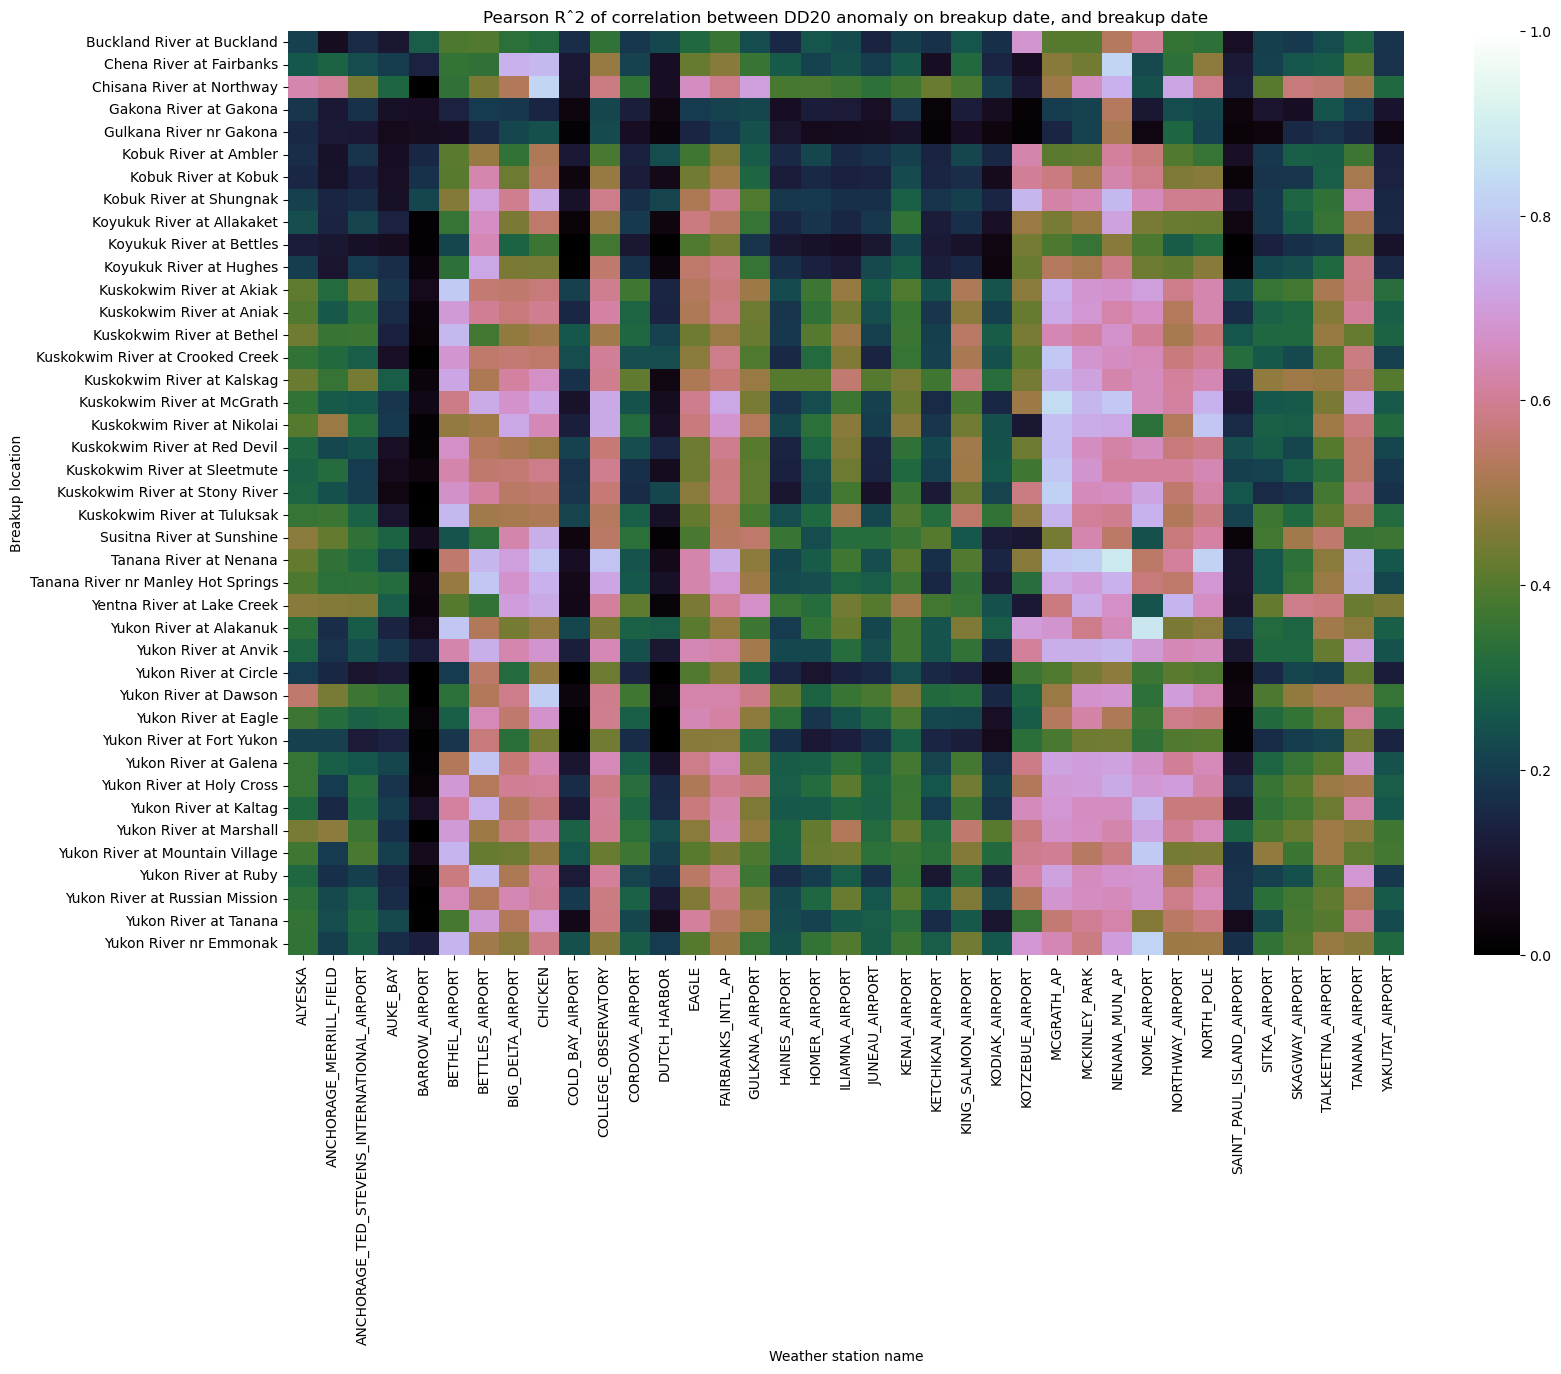

In [59]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between {prefix} anomaly on breakup date, and breakup date")

Text(0.5, 1.0, 'Log10 of p-value of correlation between TDD anomaly and breakup date')

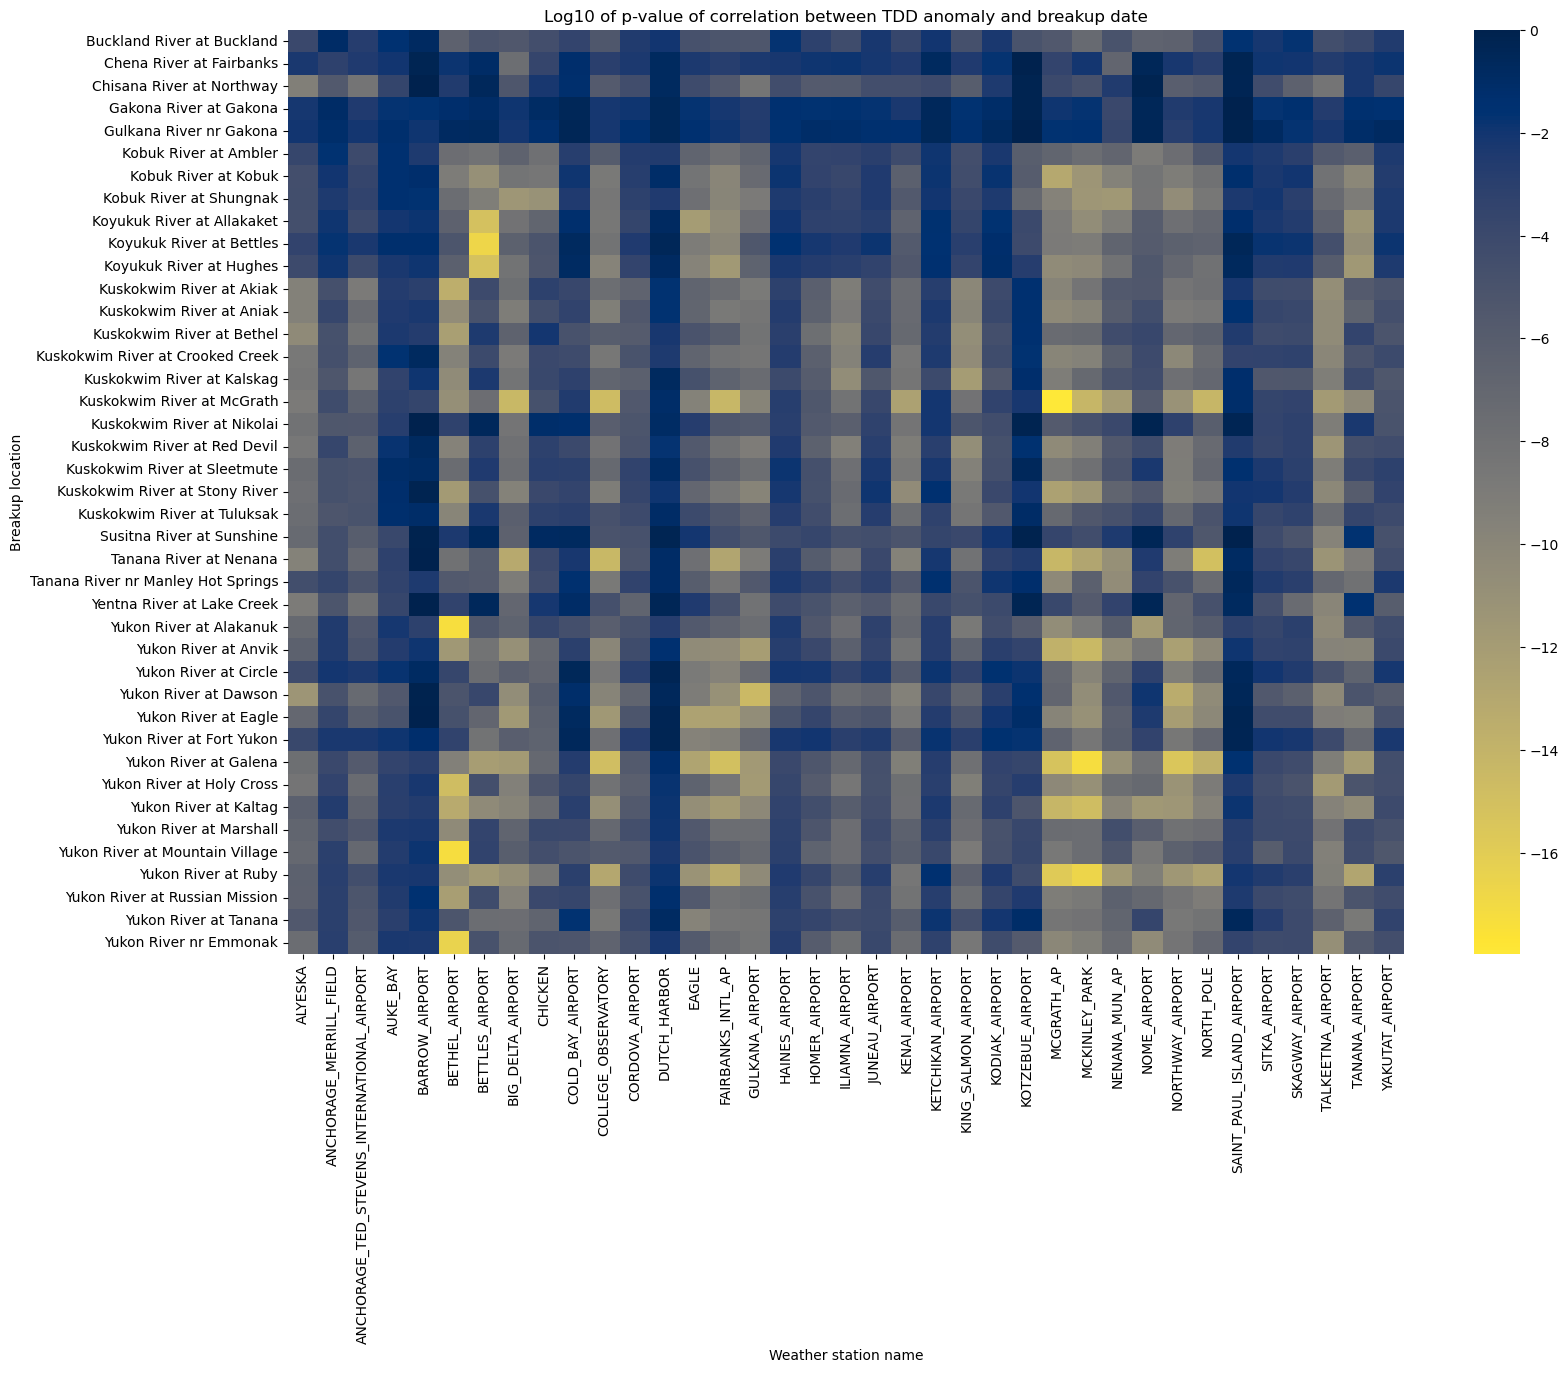

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    np.log10(resultsDF_p), 
    cmap='cividis_r', xticklabels=True, yticklabels=True)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Log10 of p-value of correlation between TDD anomaly and breakup date")

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops 

,Top1,Top2,Top3,Top4,Top5
location,,,,,
Buckland River at Buckland,BARROW_AIRPORT,ANCHORAGE_MERRILL_FIELD,AUKE_BAY,SAINT_PAUL_ISLAND_AIRPORT,HAINES_AIRPORT
Chena River at Fairbanks,KOTZEBUE_AIRPORT,BARROW_AIRPORT,SAINT_PAUL_ISLAND_AIRPORT,NOME_AIRPORT,KETCHIKAN_AIRPORT
Chisana River at Northway,BARROW_AIRPORT,NOME_AIRPORT,KOTZEBUE_AIRPORT,SAINT_PAUL_ISLAND_AIRPORT,BETTLES_AIRPORT
Gakona River at Gakona,SAINT_PAUL_ISLAND_AIRPORT,KOTZEBUE_AIRPORT,NOME_AIRPORT,COLD_BAY_AIRPORT,KETCHIKAN_AIRPORT
Gulkana River nr Gakona,KOTZEBUE_AIRPORT,SAINT_PAUL_ISLAND_AIRPORT,NOME_AIRPORT,COLD_BAY_AIRPORT,KETCHIKAN_AIRPORT
Kobuk River at Ambler,AUKE_BAY,KETCHIKAN_AIRPORT,SAINT_PAUL_ISLAND_AIRPORT,KODIAK_AIRPORT,SITKA_AIRPORT
Kobuk River at Kobuk,BARROW_AIRPORT,SAINT_PAUL_ISLAND_AIRPORT,AUKE_BAY,DUTCH_HARBOR,KODIAK_AIRPORT
Kobuk River at Shungnak,AUKE_BAY,BARROW_AIRPORT,SITKA_AIRPORT,KETCHIKAN_AIRPORT,KODIAK_AIRPORT
Koyukuk River at Allakaket,DUTCH_HARBOR,SAINT_PAUL_ISLAND_AIRPORT,COLD_BAY_AIRPORT,KODIAK_AIRPORT,KETCHIKAN_AIRPORT


Now for 15 days before breakupm

In [ ]:
breakup_anomaly_offset = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_offset[stationname] = breakup_anomaly_offset.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF, offset=10), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_offset)

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
resultsDF_p_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / "breakupdayminus15_TDD_corr_pvalues.csv", "w") as dst:
    dst.write("# Correlations between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_offset.to_csv(dst)
with open(outpath / "breakupdayminus15_TDD_corr_r2values.csv", "w") as dst:
    dst.write("# Correlation R2 between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_offset.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date')

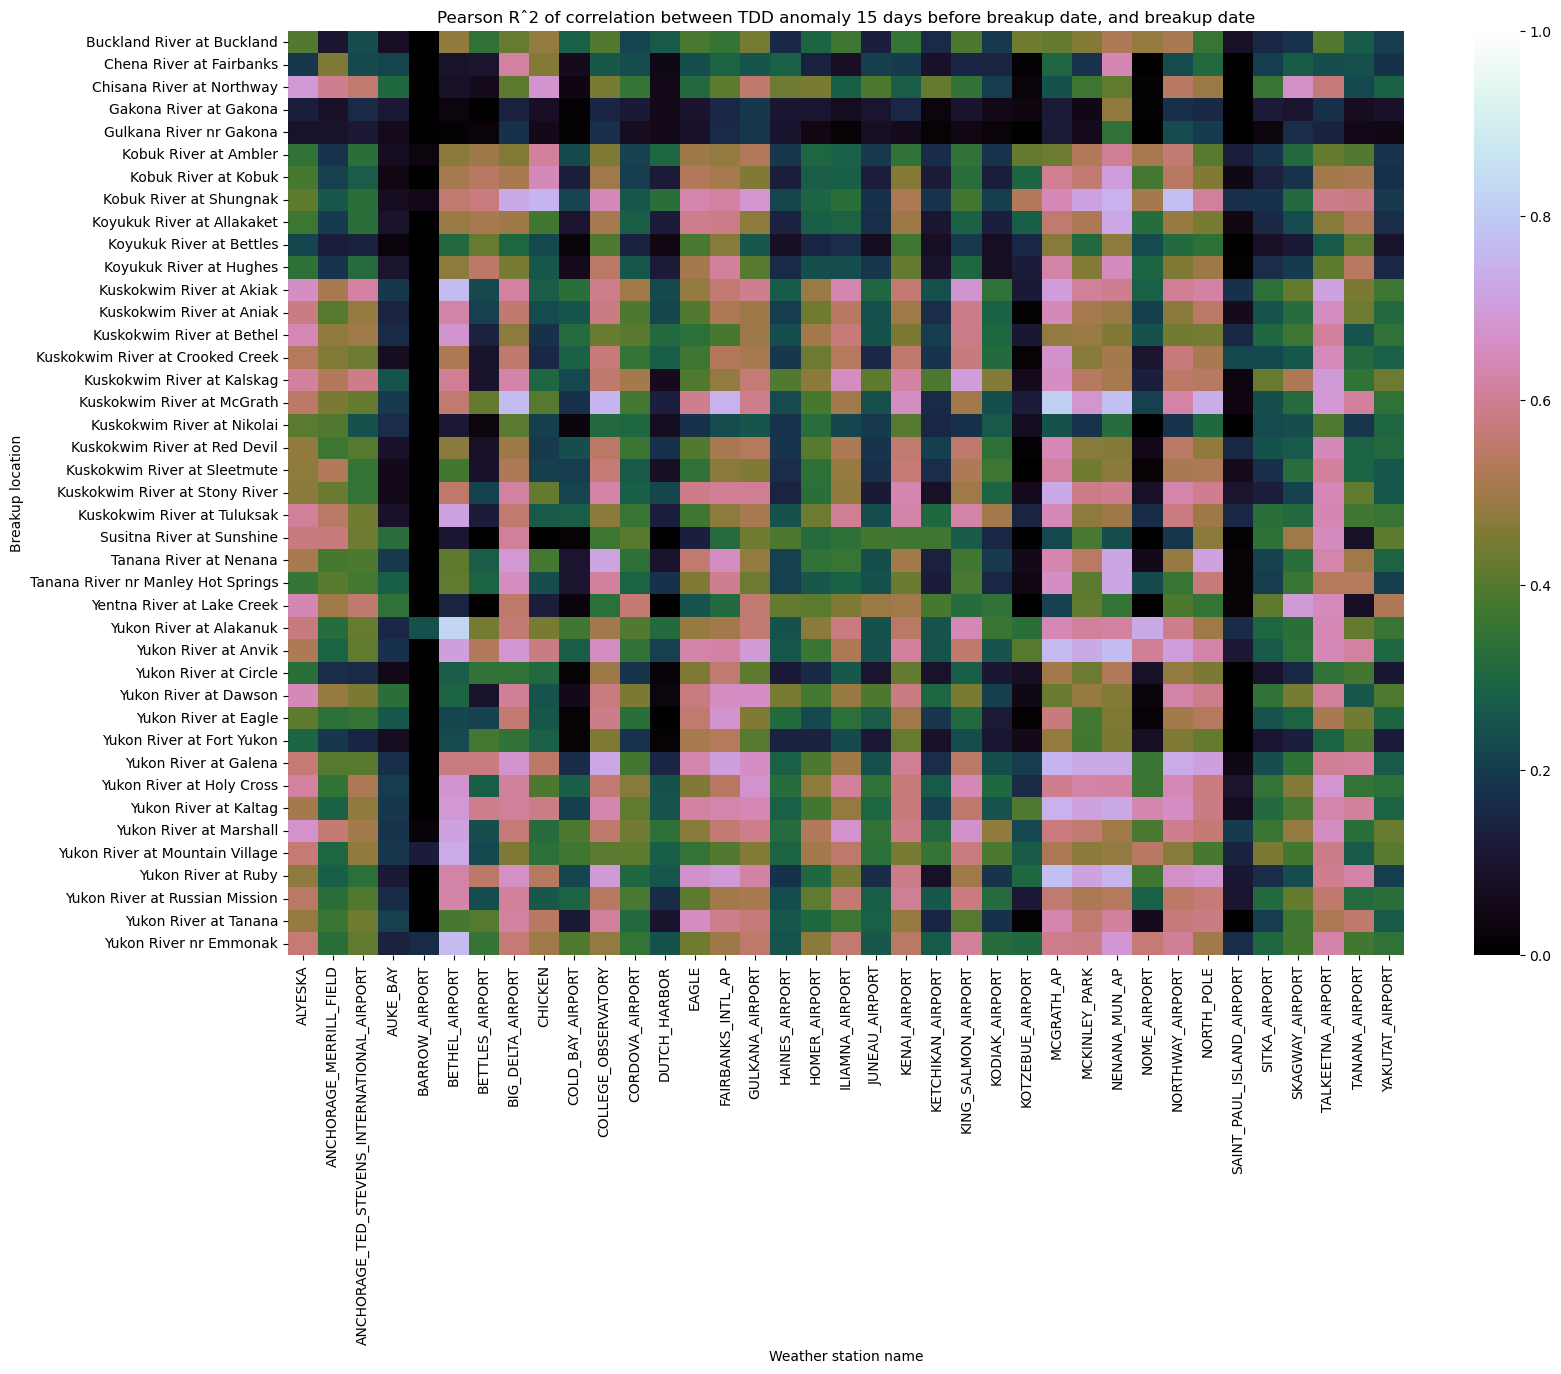

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_offset, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date")

Now for April 15th, or May 1, or whatever.

In [ ]:
datestr = "04-15"
textstr = "April 15"
fnstr = textstr.replace(" ", "")

In [ ]:
breakup_anomaly_fixed = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
        lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    # breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
    #     lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, "04-15"), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)

In [ ]:
resultsDF_p_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / f"{fnstr}_TDD_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_fixed.to_csv(dst)
with open(outpath / f"{fnstr}_TDD_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_fixed.to_csv(dst)   
    

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly on April 15, and breakup date')

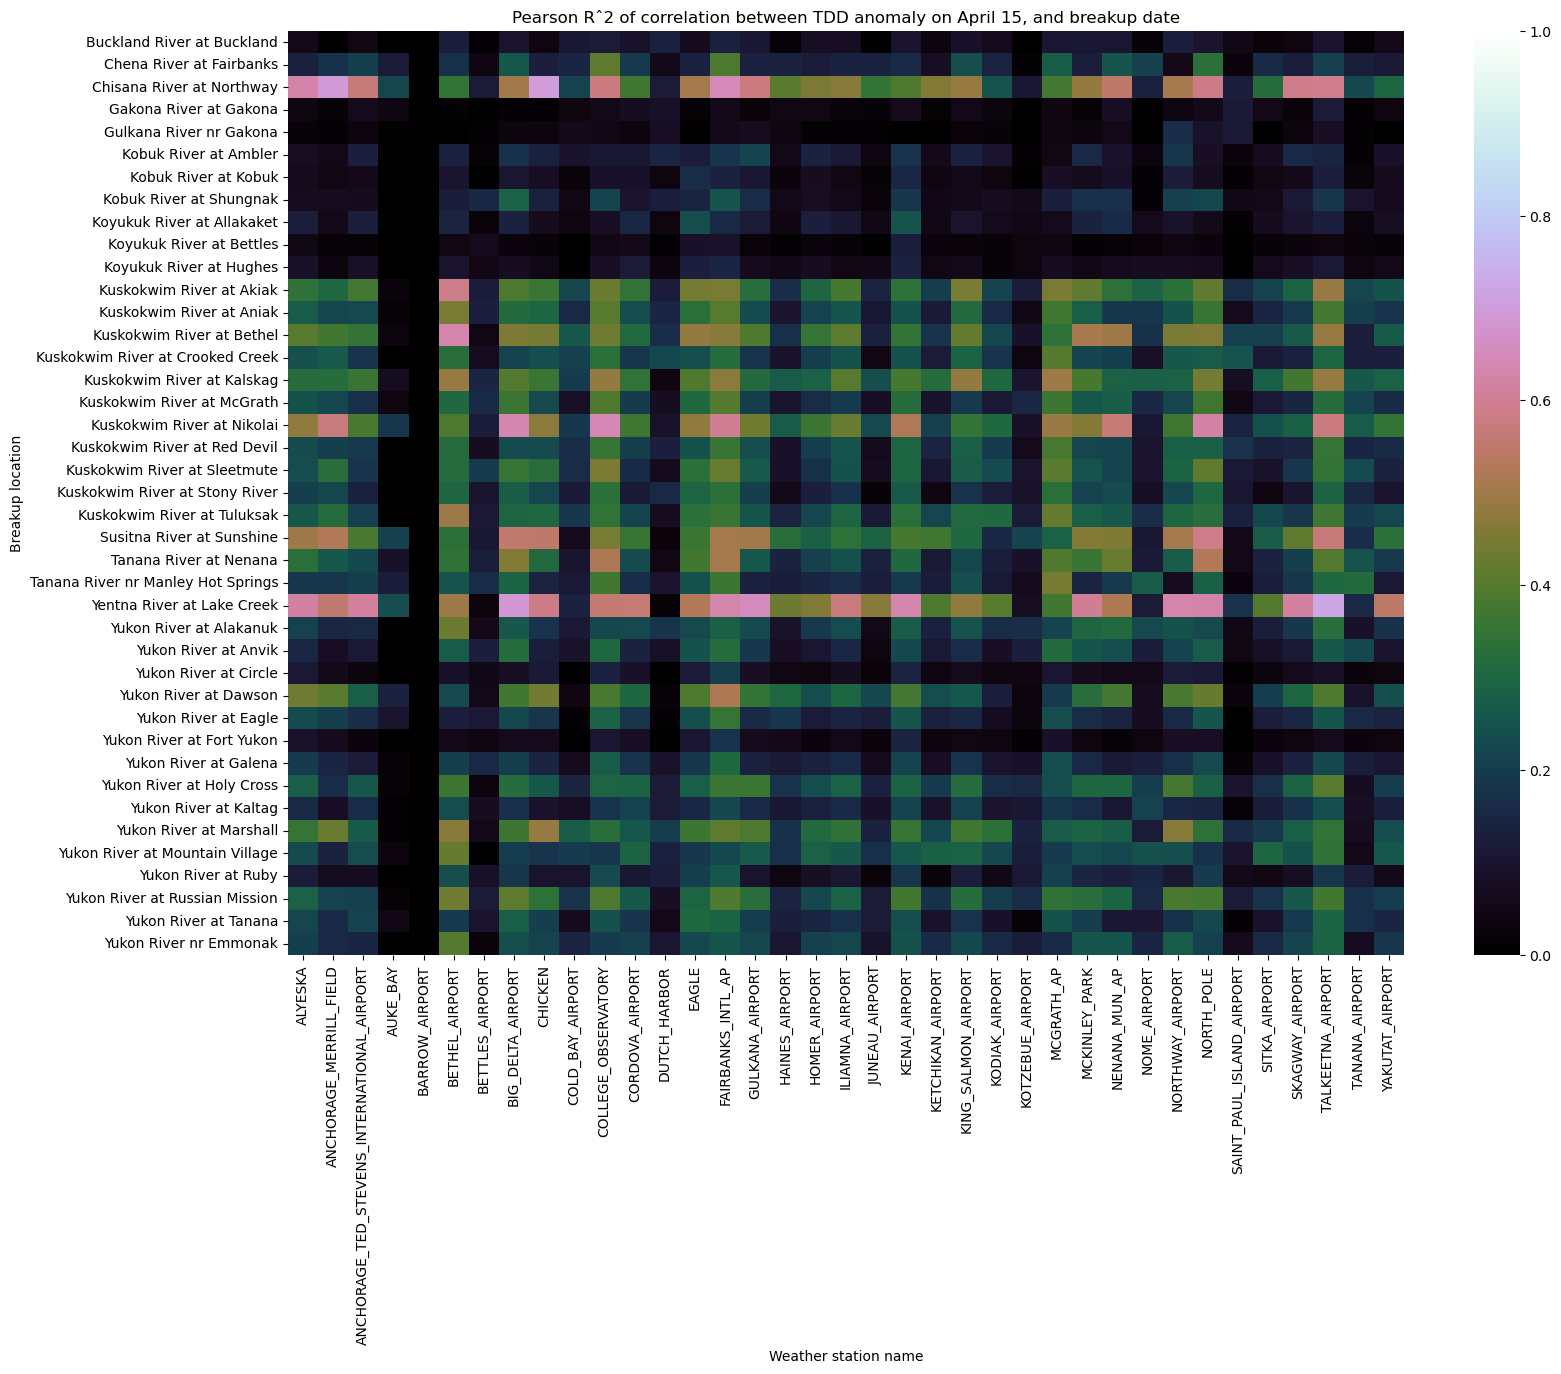

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_fixed, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between TDD anomaly on {textstr}, and breakup date")

### Write top correlations to files

In [ ]:
results_r2_dict = resultsDF_r2.T.to_dict()
topstations_breakupday = {}
for location in results_r2_dict:
    topstations_breakupday[location] = dict(sorted(results_r2_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupday.json", "w") as dst:
    json.dump(topstations_breakupday, dst, indent=2)

In [ ]:
results_r2_offset_dict = resultsDF_r2_offset.T.to_dict()
topstations_breakupdayminus15 = {}
for location in results_r2_dict:
    topstations_breakupdayminus15[location] = dict(sorted(results_r2_offset_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupdayminus15.json", "w") as dst:
    json.dump(topstations_breakupdayminus15, dst, indent=2)

In [ ]:
results_r2_April25_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April25 = {}
for location in results_r2_April25_dict:
    topstations_April25[location] = dict(sorted(results_r2_April25_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April25.json", "w") as dst:
    json.dump(topstations_April25, dst, indent=2)

In [ ]:
results_r2_April15_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April15 = {}
for location in results_r2_April15_dict:
    topstations_April15[location] = dict(sorted(results_r2_April15_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April15.json", "w") as dst:
    json.dump(topstations_April15, dst, indent=2)

In [ ]:
import itertools

In [ ]:
maxN = 5
resultsdicts = {"breakupday": topstations_breakupday, 
                "breakupdayminus15": topstations_breakupdayminus15, 
                "April25": topstations_April25, 
                "April15": topstations_April15}

roundrobin = itertools.cycle(resultsdicts)

selectedstations = {}
locations = resultsdicts["breakupday"].keys()
for location in locations:
    print(f"Working on {location}")
    selectedstations[location] = set()
    ii = 0
    jj = 0
    for label in roundrobin:
        dict = resultsdicts[label]
        print(f"For {label}...")
        try:
            print(f"Retrieving element {ii}: {sorted(dict[location].items(), key=lambda x: -x[1])[ii][0]}")
            selectedstations[location].add(sorted(dict[location].items(), key=lambda x: -x[1])[ii][0])
        except IndexError:
            continue
        jj += 1
        ii = jj // 4 
        if len(selectedstations[location]) == maxN:
            selectedstations[location] = list(selectedstations[location])
            break


Working on Buckland River at Buckland
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 0: KOTZEBUE_AIRPORT
For April15...
Retrieving element 0: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: MCKINLEY_PARK
For breakupdayminus15...
Retrieving element 1: NORTHWAY_AIRPORT
Working on Chena River at Fairbanks
For April25...
Retrieving element 0: NENANA_MUN_AP
For April15...
Retrieving element 0: COLLEGE_OBSERVATORY
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 1: COLLEGE_OBSERVATORY
For April15...
Retrieving element 1: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: BIG_DELTA_AIRPORT
For breakupdayminus15...
Retrieving element 1: BIG_DELTA_AIRPORT
For April25...
Retrieving element 2: BIG_DELTA_AIRPORT
For April15...
Retrieving element 2: NORTH_POLE
Working on Chisana Rive

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops.to_json()

'{"Top1":{"Buckland River at Buckland":"BARROW_AIRPORT","Chena River at Fairbanks":"KOTZEBUE_AIRPORT","Chisana River at Northway":"BARROW_AIRPORT","Gakona River at Gakona":"SAINT_PAUL_ISLAND_AIRPORT","Gulkana River nr Gakona":"KOTZEBUE_AIRPORT","Kobuk River at Ambler":"AUKE_BAY","Kobuk River at Kobuk":"BARROW_AIRPORT","Kobuk River at Shungnak":"AUKE_BAY","Koyukuk River at Allakaket":"DUTCH_HARBOR","Koyukuk River at Bettles":"SAINT_PAUL_ISLAND_AIRPORT","Koyukuk River at Hughes":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Akiak":"KOTZEBUE_AIRPORT","Kuskokwim River at Aniak":"KOTZEBUE_AIRPORT","Kuskokwim River at Bethel":"KOTZEBUE_AIRPORT","Kuskokwim River at Crooked Creek":"BARROW_AIRPORT","Kuskokwim River at Kalskag":"DUTCH_HARBOR","Kuskokwim River at McGrath":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Nikolai":"BARROW_AIRPORT","Kuskokwim River at Red Devil":"BARROW_AIRPORT","Kuskokwim River at Sleetmute":"KOTZEBUE_AIRPORT","Kuskokwim River at Stony River":"BARROW_AIRPORT","Kus

In [ ]:
selectedstations

{'Buckland River at Buckland': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'MCKINLEY_PARK',
  'KOTZEBUE_AIRPORT'],
 'Chena River at Fairbanks': ['FAIRBANKS_INTL_AP',
  'NENANA_MUN_AP',
  'BIG_DELTA_AIRPORT',
  'NORTH_POLE',
  'COLLEGE_OBSERVATORY'],
 'Chisana River at Northway': ['SKAGWAY_AIRPORT',
  'ALYESKA',
  'CHICKEN',
  'ANCHORAGE_MERRILL_FIELD',
  'GULKANA_AIRPORT'],
 'Gakona River at Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'GULKANA_AIRPORT',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'TALKEETNA_AIRPORT'],
 'Gulkana River nr Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'GULKANA_AIRPORT',
  'NORTH_POLE'],
 'Kobuk River at Ambler': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'CHICKEN',
  'GULKANA_AIRPORT',
  'KOTZEBUE_AIRPORT'],
 'Kobuk River at Kobuk': ['NENANA_MUN_AP',
  'EAGLE',
  'KENAI_AIRPORT',
  'CHICKEN',
  'BIG_DELTA_AIRPORT'],
 'Kobuk River at Shungnak': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP'

In [ ]:
with open(outpath / "selectedstations.json", "w") as dst:
    json.dump(selectedstations, dst, indent=2)